In [3]:
pip install graphviz

You should consider upgrading via the 'c:\python\venv\tensorflow\scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# <font color = #FFFF923>Data Load</font>

In [5]:
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape, type(X_train), y_train.shape, type(y_train), X_test.shape

((60000, 28, 28), numpy.ndarray, (60000,), numpy.ndarray, (10000, 28, 28))

In [6]:
#train_data
X = X_train[:2000].reshape(-1, 784)  
y = y_train[:2000]

In [7]:
X.shape, y.shape

((2000, 784), (2000,))

In [8]:
from sklearn.model_selection import train_test_split

X, X_t, y, y_t = train_test_split(X,y,test_size = 0.5, random_state = 42)

In [9]:
X_t.shape, y_t.shape

((1000, 784), (1000,))

In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names[9]

'Ankle boot'

Text(0.5, 1.0, 'Pullover')

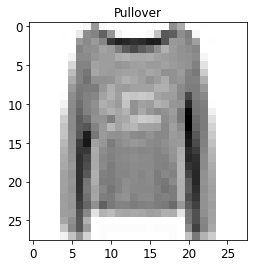

In [11]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

idx = 0
some_digit = X[idx]
some_digit_image = some_digit.reshape(28,28)
some_digit_label = y[idx]
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.title(class_names[some_digit_label])

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [13]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

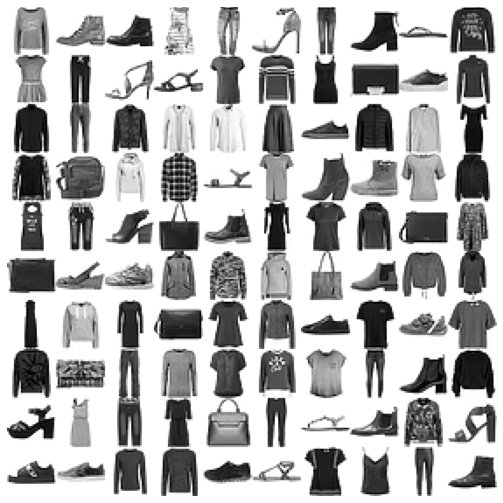

In [14]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

# <font color = fff923> Training(decision tree) </font>

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X, y)
tree_clf_score = tree_clf.score(X_t, y_t)

tree_cv = cross_val_score(tree_clf, X, y, cv = 3, scoring = 'accuracy').mean()

print('train accuracy : {:.6f}\ntest accuracy : {:.6f}'.format(tree_cv, tree_clf_score))

train accuracy : 0.685982
test accuracy : 0.695000


# <font color = fff923> Parameter tuning(decision tree) </font>

In [17]:
#RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_tree_R = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : randint(low = 1, high = 100),
    'max_features' : randint(1,9),
    'max_leaf_nodes' : randint(1,500)
}

rnd_search_tree= RandomizedSearchCV(tree_clf, param_distributions = param_tree_R,
                                n_iter = 200, cv = 3, scoring = 'accuracy',
                                random_state = 42, n_jobs = -1)
rnd_search_tree.fit(X, y)
rnd_search_tree_score = rnd_search_tree.score(X_t, y_t)

In [18]:
rnd_search_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 69,
 'max_features': 4,
 'max_leaf_nodes': 98}

In [19]:
print('train accuracy : {:.6f}  test accuracy : {:.6f}'.format(cross_val_score(rnd_search_tree, X, y, cv = 3, scoring = 'accuracy').mean(), rnd_search_tree_score))

train accuracy : 0.590980  test accuracy : 0.669000


In [22]:
#gridSearch
from sklearn.model_selection import GridSearchCV

param_tree_G = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1,100),
    'max_features' : range(1,9),
    'max_leaf_nodes' : range(1,100,3)
}

rnd_search_tree_ = GridSearchCV(tree_clf, param_grid = param_tree_G, cv=3, verbose = 1, n_jobs=-1)
rnd_search_tree_.fit(X, y)

Fitting 3 folds for each of 52272 candidates, totalling 156816 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 4920 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 10520 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 17720 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 26520 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 36920 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 48920 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 62520 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 77720 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 94520 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 112920 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 132920 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154520 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 100),
                         'max_features': range(1, 9),
                         'max_leaf_nodes': range(1, 100, 3)},
             verbose=1)

In [23]:
rnd_search_tree_.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 4,
 'max_leaf_nodes': 37}

In [26]:
print('train accuracy : {:.6f}  test accuracy : {:.6f}'.format(cross_val_score(rnd_search_tree_, X, y, cv = 3, scoring = 'accuracy').mean(), rnd_search_tree_.score(X_t, y_t)))

Fitting 3 folds for each of 52272 candidates, totalling 156816 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2536 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 10536 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 21736 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 36136 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 53736 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 74536 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 98536 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 125736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 156136 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 156816 out of 156816 | elapsed:  1.6min finished


Fitting 3 folds for each of 52272 candidates, totalling 156816 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2536 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 10536 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 21736 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 36136 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 53736 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 74536 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 98536 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 125736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 156136 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 156816 out of 156816 | elapsed:  1.6min finished


Fitting 3 folds for each of 52272 candidates, totalling 156816 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2536 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 10536 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 21736 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 36136 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 53736 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 74536 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 98536 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 125736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 156136 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 156816 out of 156816 | elapsed:  1.7min finished


train accuracy : 0.641027  test accuracy : 0.664000


# <font color = fff923> Training(SVM) </font>

In [28]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_s = scaler.fit_transform(X)
X_t_s = scaler.fit_transform(X_t)

svc_clf = SVC(random_state = 42)
svc_clf.fit(X_s,y)

svc_score_test = svc_clf.score(X_t_s, y_t)
print('train accuracy : {}\ntest accuracy : {}'.format(cross_val_score(svc_clf,X_s,y,cv=3,scoring = 'accuracy').mean(),svc_score_test))

train accuracy : 0.7889955824087561
test accuracy : 0.81


# <font color = fff923> Parameter tuning(SVM) </font>

In [29]:
from sklearn.model_selection import GridSearchCV

param_svm = [
    {'kernel' : ['linear', 'rbf', 'poly'],'C' : [1,10,100,0.1,0.01,0.001], 'gamma' : ['scale',1,0.1,0.01,0.001,0.0001]}
]

svm_reg = SVC(random_state=42)
grid_search_svm = GridSearchCV(svm_reg, param_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_s,y)

grid_search_svm.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [30]:
print('train accuracy : {} test accuracy : {}'.format(cross_val_score(grid_search_svm,X_s,y,cv=3,scoring = 'accuracy').mean(), grid_search_svm.score(X_t_s, y_t)))

train accuracy : 0.8109846373319427 test accuracy : 0.821


# <font color = fff923> Training(RandomForestClassifier) </font>

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X,y)

print('train accuracy : {} test accuracy : {}'.format(cross_val_score(forest_clf,X,y,cv=3,scoring = 'accuracy').mean(), forest_clf.score(X_t, y_t)))

train accuracy : 0.8119946293598987 test accuracy : 0.822


In [33]:
#Gridsearch
param_forest = [
    {'n_estimators' : [1,10,100], 'max_features' : [2,4,6,8]},
    {'bootstrap' : [False], 'n_estimators' : [3, 10], 'max_features' : [2,3,4]},
]

forest_grid = GridSearchCV(forest_clf, param_forest, cv=3, scoring = 'accuracy')
forest_grid.fit(X,y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [1, 10, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='accuracy')

In [34]:
forest_grid.best_params_

{'max_features': 8, 'n_estimators': 100}

In [35]:
print('train accuracy : {:.6f}  test accuracy : {:.6f}'.format(cross_val_score(forest_grid,X,y,cv=3,scoring = 'accuracy').mean(), forest_grid.score(X_t, y_t)))

train accuracy : 0.803034  test accuracy : 0.811000


In [37]:
#RandomizedSearch
param_forest_rnd = {
    'n_estimators' : randint(low=1, high = 500),
    'max_features' : randint(low = 1, high = 8),
}

forest_rnd_grid = RandomizedSearchCV(forest_clf, param_forest_rnd, n_iter = 100, cv=3, scoring = 'accuracy', random_state = 42)
forest_rnd_grid.fit(X,y)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021D7C1BF5C8>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021D7C1BF708>},
                   random_state=42, scoring='accuracy')

In [38]:
forest_rnd_grid.best_params_

{'max_features': 3, 'n_estimators': 459}

In [39]:
print('train accuracy : {:.6f}  test accuracy : {:.6f}'.format(cross_val_score(forest_rnd_grid, X,y, cv=3, scoring = 'accuracy').mean(),forest_rnd_grid.score(X_t,y_t) ))

train accuracy : 0.808000  test accuracy : 0.819000


In [40]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(forest_clf,X,y, cv = 3)
conf_mx = confusion_matrix(y, y_pred)
conf_mx

array([[ 87,   1,   1,   8,   0,   1,   8,   0,   1,   0],
       [  1, 114,   2,   5,   1,   0,   0,   0,   0,   0],
       [  2,   0,  70,   1,  19,   1,   6,   0,   0,   0],
       [  6,   0,   2,  88,   2,   0,   2,   0,   0,   0],
       [  0,   0,  14,   8,  53,   0,   3,   0,   0,   0],
       [  0,   0,   0,   0,   0,  94,   0,   3,   0,   5],
       [ 24,   1,  17,   3,  10,   0,  38,   0,   3,   0],
       [  0,   0,   0,   0,   0,   6,   0,  90,   0,   7],
       [  0,   0,   1,   1,   0,   3,   1,   1,  87,   0],
       [  0,   0,   0,   0,   0,   1,   0,   6,   0,  91]], dtype=int64)

In [41]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/ row_sums
norm_conf_mx

array([[0.81308411, 0.00934579, 0.00934579, 0.07476636, 0.        ,
        0.00934579, 0.07476636, 0.        , 0.00934579, 0.        ],
       [0.00813008, 0.92682927, 0.01626016, 0.04065041, 0.00813008,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.02020202, 0.        , 0.70707071, 0.01010101, 0.19191919,
        0.01010101, 0.06060606, 0.        , 0.        , 0.        ],
       [0.06      , 0.        , 0.02      , 0.88      , 0.02      ,
        0.        , 0.02      , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.17948718, 0.1025641 , 0.67948718,
        0.        , 0.03846154, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.92156863, 0.        , 0.02941176, 0.        , 0.04901961],
       [0.25      , 0.01041667, 0.17708333, 0.03125   , 0.10416667,
        0.        , 0.39583333, 0.        , 0.03125   , 0.        ],
       [0.        , 0.        , 0.       

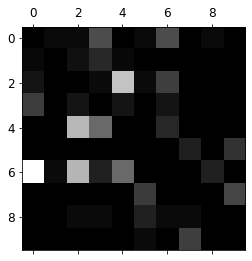

In [42]:
#confusion_matrix plot
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [43]:
from sklearn.metrics import precision_score, recall_score

precision_score(y, y_pred, average = 'macro')

0.8038927432790717

In [44]:
recall_score(y, y_pred, average = 'macro')

0.8051762979016452

In [47]:
from sklearn.metrics import f1_score

f1_score(y, y_pred,average = 'macro')

0.8002908356778058

그림 저장: error_analysis_digits_plot


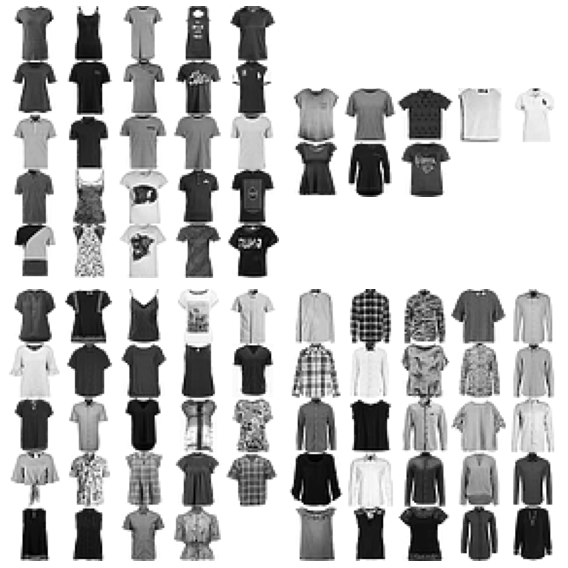

In [45]:
cl_a, cl_b = 0, 6
X_aa = X[(y == cl_a) & (y_pred == cl_a)]
X_ab = X[(y == cl_a) & (y_pred == cl_b)]
X_ba = X[(y == cl_b) & (y_pred == cl_a)]
X_bb = X[(y == cl_b) & (y_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()